# RippleNet_timeseries_prediction_raw_LFP
Simple recurrent neural network (RNN) implementation in Keras using LSTM (long short-term memory) units to identify time of occurence of some events in temporal data

In [1]:
# allow running on Google Colab for training. 
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My\ Drive/Colab\ Notebooks/NN_Ripple_Detection/neural_networks
    %tensorflow_version 2.x
except:
    pass

In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow
import tensorflow as tf
from tensorflow import keras
import h5py # TODO: use tensorflow.keras.utils.HDF5Matrix
from matplotlib import colors
import seaborn as sns
import pandas as pd
import pickle
from ripplenet.common import *

In [4]:
plt.rcParams.update({'figure.max_open_warning': 100})
plt.rcParams.update(rcParams)

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4986298746899089951
]


In [6]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0

Num GPUs Available:  0


In [7]:
# fix seeds
np.random.seed(1234)
tf.random.set_seed(12345)

# Predictions on continuous timeseries

## load neural network from file

In [8]:
# load info on best model (path, threhsold settings)
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)
    print(best_model)

{'model_file': 'trained_networks/ripplenet_bidirectional_random_seed123.h5', 'threshold': 0.7, 'width': 0.0, 'distance': 62}


In [9]:
# load the 'best' performing model on the validation sets
model = keras.models.load_model(best_model['model_file'])

model.summary()

Model: "RippleNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 20)          220       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20)          80        
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 10)          2210      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 10)          40

In [10]:
# Threshold for detecting event from prediction
threshold = best_model['threshold']
distance = best_model['distance']
width = best_model['width']

## load a session time series

In [11]:
# some needed parameters
Fs = 1250 # Hz, sampling freq

# width of boxcar around each labeled event
y_label_width = int(50 * Fs / 1000) # 50 ms @ Fs

In [12]:
# open file with complete time series
session = 'm4029_session1'  # holdout dataset
f = h5py.File(os.path.join('..', 'data', 'processed', '{}.h5'.format(session)), 'r')

In [13]:
# list sessions:
list(f.items())

[('m4029_session1', <HDF5 group "/m4029_session1" (7 members)>)]

In [14]:
list(f[session].items())

[('S', <HDF5 dataset "S": shape (753914, 16), type "<f8">),
 ('S_freqs', <HDF5 dataset "S_freqs": shape (16,), type "<f8">),
 ('X1', <HDF5 dataset "X1": shape (753914,), type "<f8">),
 ('lfp', <HDF5 dataset "lfp": shape (753914,), type "<f8">),
 ('rippleLocs', <HDF5 dataset "rippleLocs": shape (86,), type "<i4">),
 ('run_speed', <HDF5 dataset "run_speed": shape (753914,), type "<i4">),
 ('y', <HDF5 dataset "y": shape (753914,), type "<f8">)]

## Run prediction on entire dataset

In [15]:
list(f[session].items())

[('S', <HDF5 dataset "S": shape (753914, 16), type "<f8">),
 ('S_freqs', <HDF5 dataset "S_freqs": shape (16,), type "<f8">),
 ('X1', <HDF5 dataset "X1": shape (753914,), type "<f8">),
 ('lfp', <HDF5 dataset "lfp": shape (753914,), type "<f8">),
 ('rippleLocs', <HDF5 dataset "rippleLocs": shape (86,), type "<i4">),
 ('run_speed', <HDF5 dataset "run_speed": shape (753914,), type "<i4">),
 ('y', <HDF5 dataset "y": shape (753914,), type "<f8">)]

In [16]:
# load data (cont. LFP and ripple locations for plotting)
X0_cont = np.expand_dims(np.expand_dims(f[session]['lfp'][:], 0), -1) # input must have shape (n_samples, n_timesteps, 1)
rippleLocs = f[session]['rippleLocs'][:]
S_freqs = f[session]['S_freqs'][:]

In [17]:
# imshow color limits
vmin, vmax = np.exp(np.percentile(np.log(f[session]['S'][:Fs*30, :].flatten()), [1, 99]))

In [18]:
# Switch or reshaping input into segments, or running on full time series
if False:
    # Predict using entire dataset at once (not recommended)
    Y_cont_pred = model.predict(X0_cont)
else:
    # Reshape time axis to segments of Fs duration
    segment_length = int(0.5 * Fs) # Fs
    #segment_length = int(1 * Fs) # Fs

    # run predictions n times with shifts of length segment_length / n,
    # then final output will be averaged
    n = 5 # nicely divisible with Fs=1250
    shift = int(segment_length / n)
    container = []
    for i in range(n):
        X0_cont_padded = np.concatenate((np.zeros((1, i * shift, 1)), X0_cont), axis=1)

        # pad with zeros 
        X0_cont_padded = np.concatenate((X0_cont_padded, 
                                         np.zeros((1, segment_length - 
                                                   (X0_cont_padded.size % segment_length), 1))), 
                                        axis=1)
        
        # reshape into segments of length  
        X0_cont_padded = X0_cont_padded.reshape((-1, segment_length, 1))

        # run prediction on data
        Y_cont_pred = model.predict(X0_cont_padded)

        # Reshape to zero-padded size
        Y_cont_pred = Y_cont_pred.reshape((1, -1, 1))[:, :X0_cont_padded.size, :]

        # strip elements that were padded with zeros
        container.append(Y_cont_pred[:, i * shift:i * shift + X0_cont.size, :])

    # average or median
    Y_cont_pred = np.median(container, axis=0)

    # remove intermediate predictions
    del container

In [19]:
# compare ground truth times vs. predicted times
peaks, _ = ss.find_peaks(Y_cont_pred[0, :, 0], height=threshold, distance=distance, width=width)

In [20]:
TPs, FPs, FNs, stats = get_TPs_FPs_FNs_stats(f[session]['y'][:].flatten(), 
                                             Y_cont_pred.flatten(), 
                                             f[session]['rippleLocs'][:], 
                                             threshold, distance, width,
                                             y_label_width=y_label_width)

In [21]:
stats

TP   FP  FN  FP+FN  precision  recall    F_1
0  78  104   8    112      0.429   0.907  0.582

In [22]:
print(stats.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 TP &   FP &  FN &  FP+FN &  precision &  recall &    F\_1 \\
\midrule
 78 &  104 &   8 &    112 &      0.429 &   0.907 &  0.582 \\
\bottomrule
\end{tabular}



In [23]:
# add label and color to each event
labels = []
for p in peaks:
    if p in TPs:
        labels.append([p, 'TP', 'C2'])
    elif p in FPs:
        labels.append([p, 'FP', 'C1'])
    else:
        raise NotImplementedError
for p in FNs:
    labels.append([p, 'FN', 'C3'])
labels = pd.DataFrame(labels, columns=['i', 'label', 'color'])

In [24]:
# preview labels
labels

i label color
0      1991    TP    C2
1      5079    FP    C1
2     20040    FP    C1
3     32100    FP    C1
4     63304    FP    C1
..      ...   ...   ...
185  384275    FN    C3
186  495821    FN    C3
187  544726    FN    C3
188  620173    FN    C3
189  744084    FN    C3

[190 rows x 3 columns]

## Figure 5

In [25]:
def plot_figure(X0, X1, S, y, y_pred, time, rippleLocs, inds, peaks, labels):
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(11, 1, hspace=0.4, left=0.05, right=0.95, top=0.95, bottom=0.05)

    ax0 = fig.add_subplot(gs[:2, 0])
    ax0.plot(time, X0 - X0.mean(), 'k', lw=0.5,  
            label=r'$X(t)$')

    ax0.plot(rippleTimes / Fs, X0[rippleTimes-inds.min()] - X0.mean() + 0.4, 
            'C2d', ms=8, clip_on=False)    
    ax0.set_title(r'$X(t)$')
    ax0.set_ylabel('(mV)', labelpad=0)
    ax0.axis(ax0.axis('tight'))
    for spine in ['top', 'bottom', 'right']:
        ax0.spines[spine].set_visible(False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.xaxis.set_ticks_position('none')    
    annotate_subplot(ax0, ncols=3, nrows=5, letter='A')

    # band-pass filtered LFP
    ax2 = fig.add_subplot(gs[2:4, 0], sharex=ax0)
    ax2.plot(time, X1, 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
    ax2.set_title(r'$\phi_\mathrm{BP}(t)$')
    ax2.axis(ax2.axis('tight'))
    ax2.set_ylabel('(mV)', labelpad=0)
    for spine in ['top', 'bottom', 'right']:
        ax2.spines[spine].set_visible(False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.xaxis.set_ticks_position('none')    
    annotate_subplot(ax2, ncols=3, nrows=5, letter='B')

    # spectrograms
    ax3 = fig.add_subplot(gs[4:6, 0], sharex=ax0)
    im = ax3.pcolormesh(time, S_freqs, S.T, 
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno',
                        label='spectrogram')
    rect = np.array(ax3.get_position().bounds)
    rect[0] += rect[2] + 0.01
    rect[2] = 0.01
    fig = plt.gcf()
    cax = fig.add_axes(rect)
    cbar = fig.colorbar(im, cax=cax, extend='both')
    cbar.set_label('(a.u.)', labelpad=0)
    ax3.axis(ax3.axis('tight'))
    ax3.set_title(r'$S(t, f)$')
    ax3.set_ylabel('$f$ (Hz)', labelpad=0)
    ax3.set_xlabel('$t$ (s)', labelpad=0)
    annotate_subplot(ax3, ncols=3, nrows=5, letter='C')
    
    # label vector
    ax1 = fig.add_subplot(gs[7:9, 0], sharex=ax0)    
    ax1.plot(time, y, 'k', lw=0.5, clip_on=False)
    ax1.set_ylabel(r'$y(t)$', labelpad=0)
    ax1.axis(ax1.axis('tight'))
    for spine in ['top', 'bottom', 'right']:
        ax1.spines[spine].set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.xaxis.set_ticks_position('none')
    annotate_subplot(ax1, ncols=3, nrows=5, letter='D')
    ax1.set_yticks([0, 1])
    ax1.set_ylim(0, 1)

    # label vector prediction
    ax4 = fig.add_subplot(gs[9:, 0], sharex=ax0, sharey=ax1)    
    ax4.plot(time, y_pred, 'k', lw=0.5, clip_on=False, label='__nolabel__')
    #ax4.plot(time[peaks__], y_pred[peaks__]+0.1, 'kd', ms=8, clip_on=False)
    
    
    for lbl in np.unique(labels.label):
    #for _, row in labels.iterrows():
        ax4.plot(labels[labels.label==lbl].i.astype(int) / Fs, 
                 y_pred[labels[labels.label==lbl].i.astype(int)-inds.min()]+0.1, 
                 labels[labels.label==lbl].color.values[0] + 'd', 
                 ms=8, clip_on=False, 
                 label=lbl)

    ax4.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))

    
    ax4.plot([time[-1]-1, time[-1]-2], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
    ax4.text(time[-1]-1.5, -0.1, '1 s', va='top', ha='center')

    
    ax4.set_ylabel(r'$\hat{y}(t)$', labelpad=0)
    ax4.axis(ax1.axis('tight'))
    ax4.set_ylim(0, 1)
    ax4.set_yticks([0, 1])
    for spine in ['top', 'bottom', 'right']:
        ax4.spines[spine].set_visible(False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    ax4.xaxis.set_ticks_position('none')    
    ax4.set_xlim(time[0], time[-1])
    annotate_subplot(ax4, ncols=3, nrows=5, letter='E')

    return fig

In [26]:
windowsize = Fs * 10

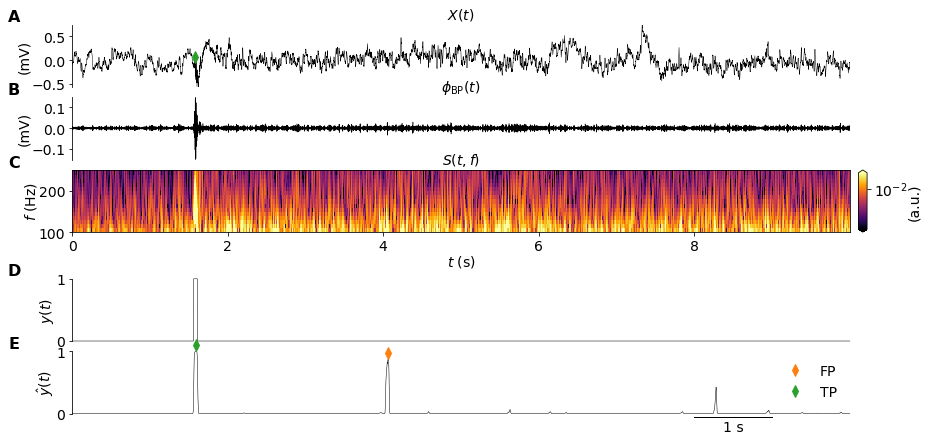

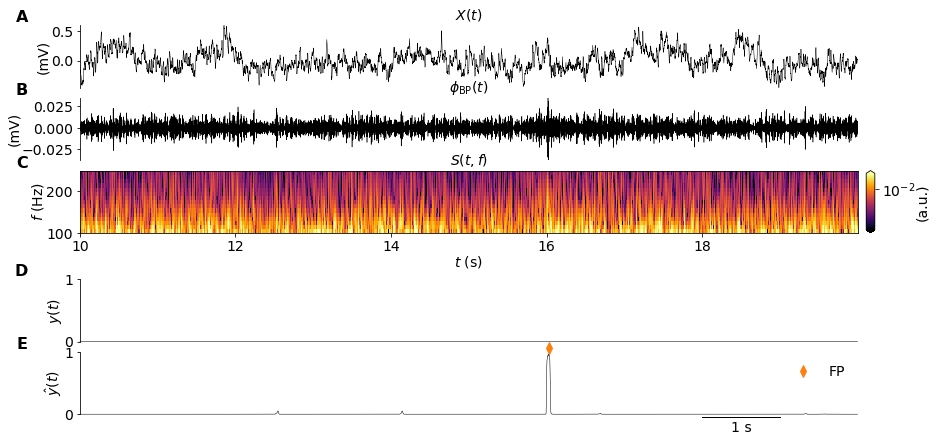

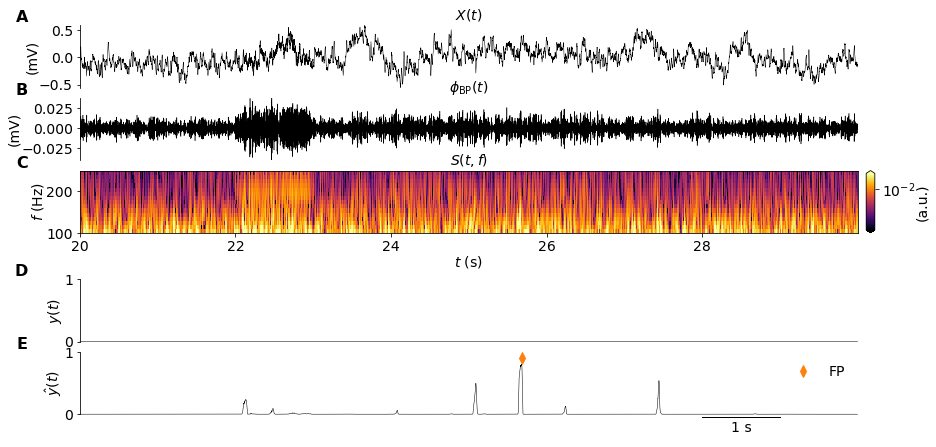

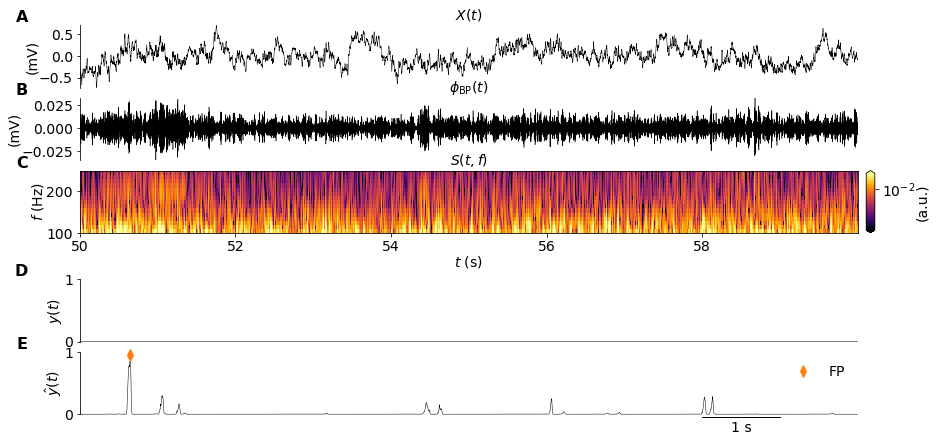

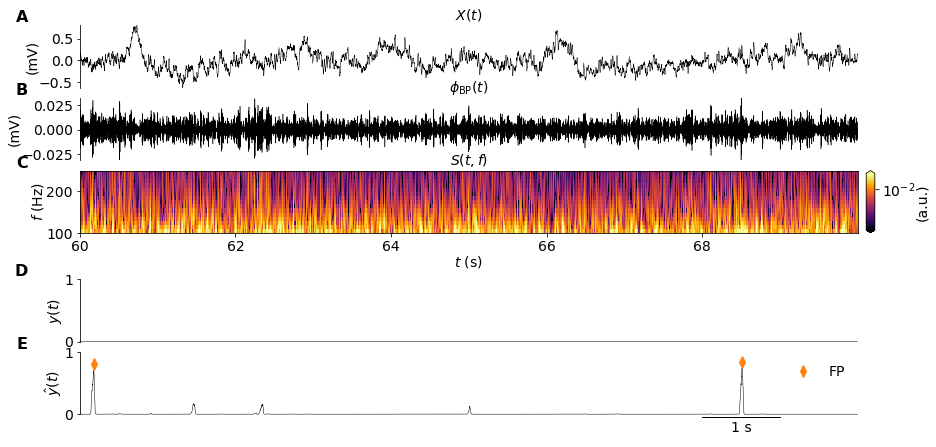

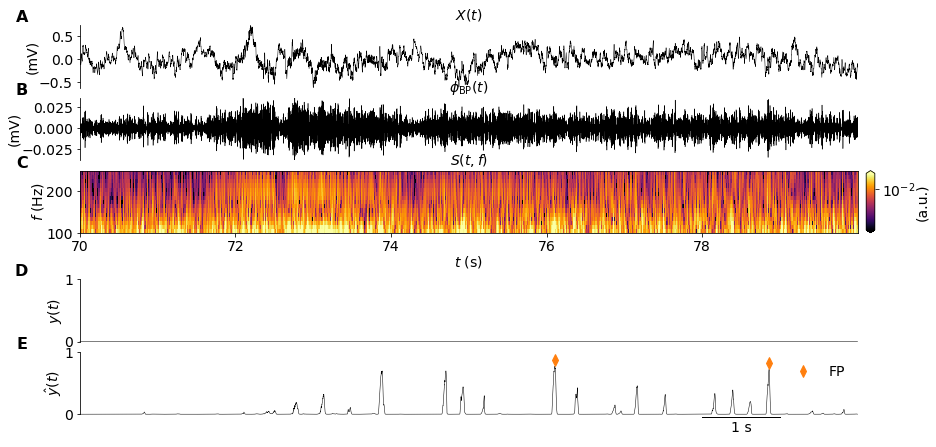

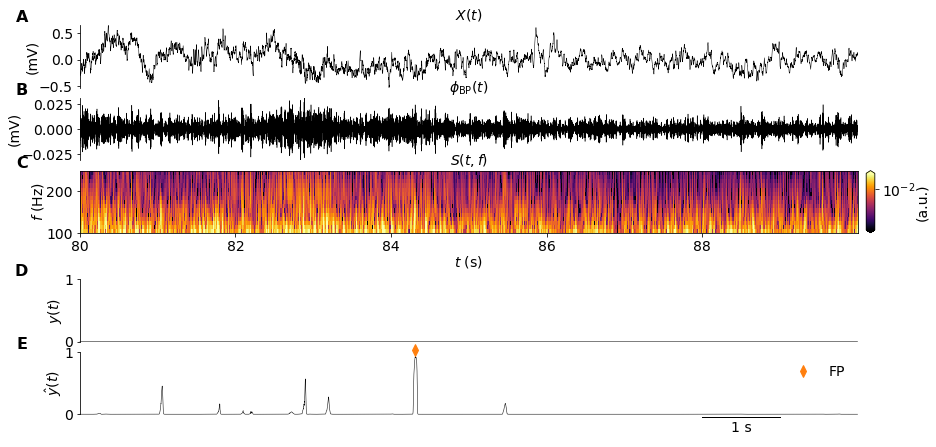

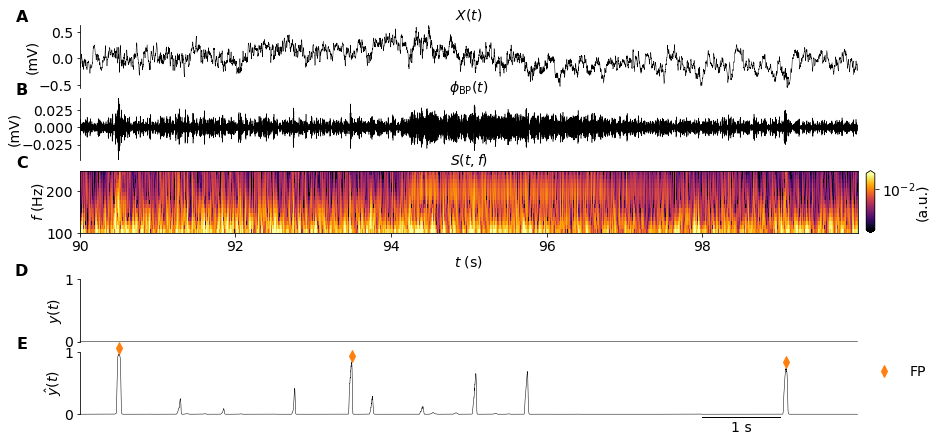

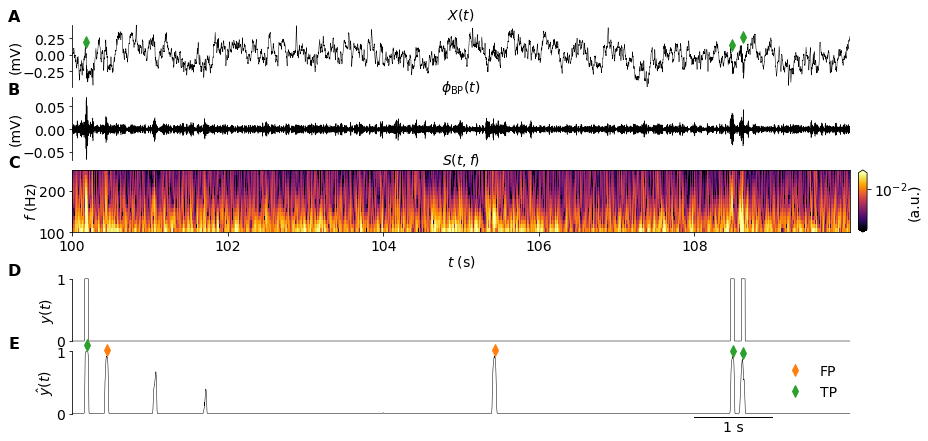

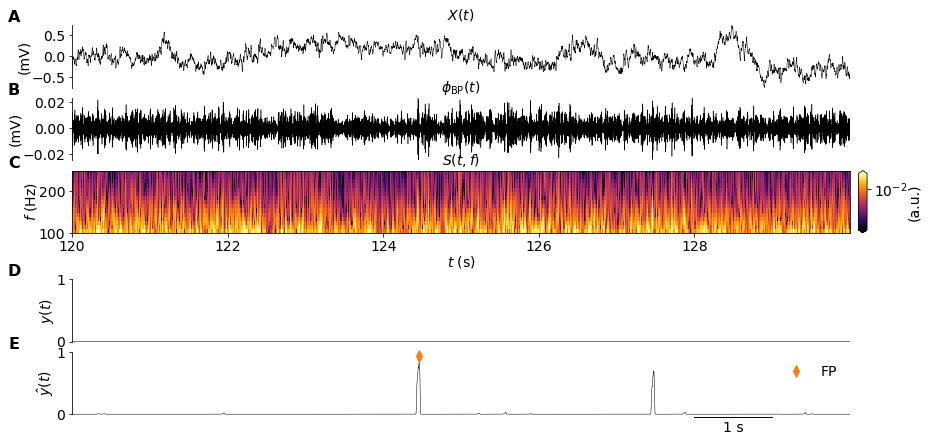

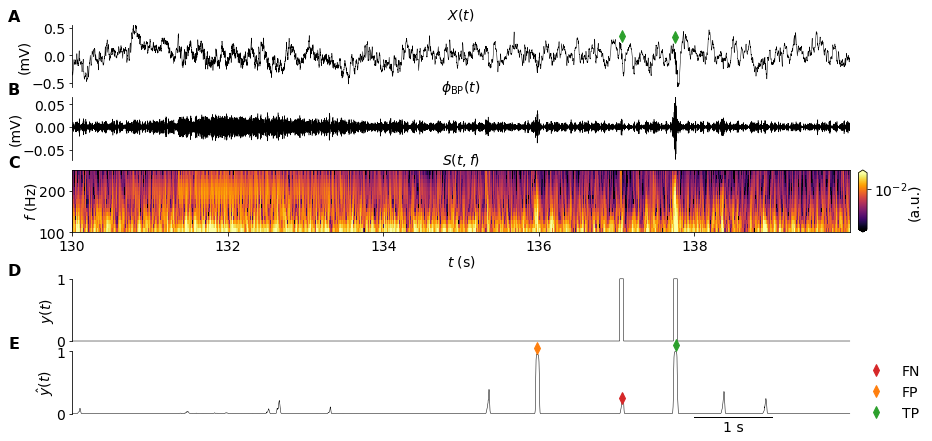

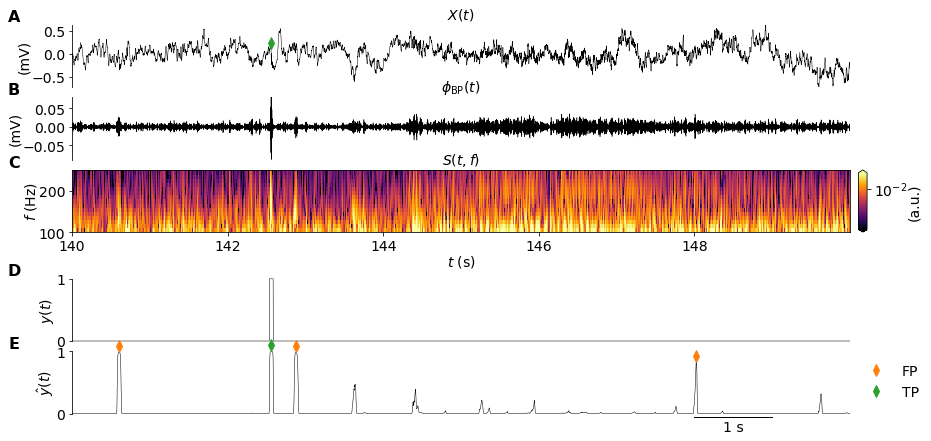

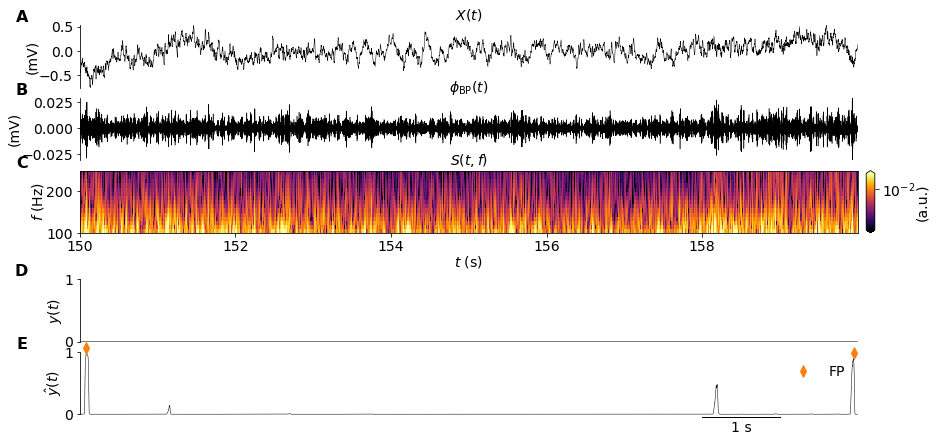

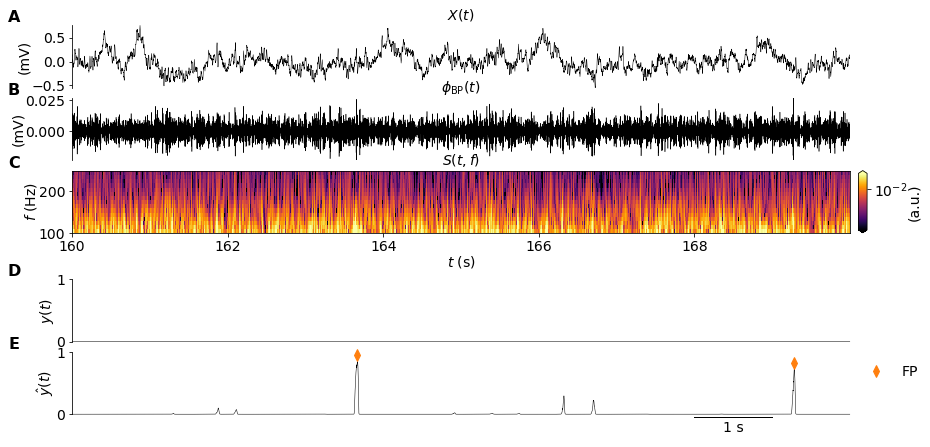

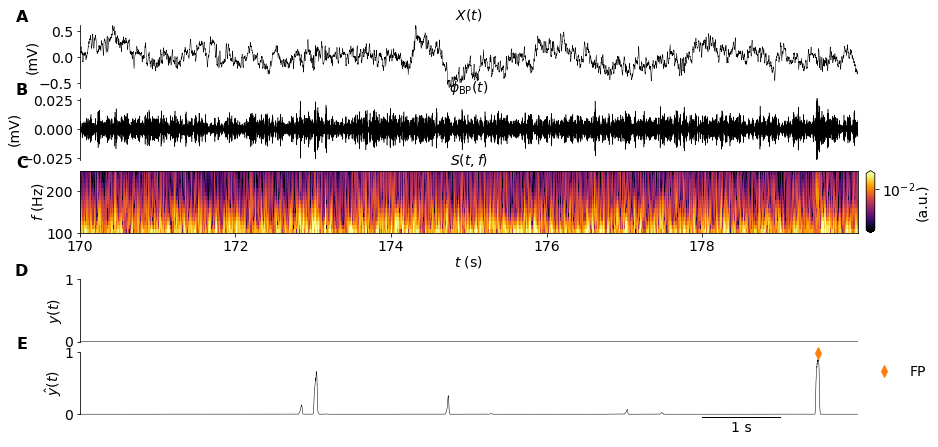

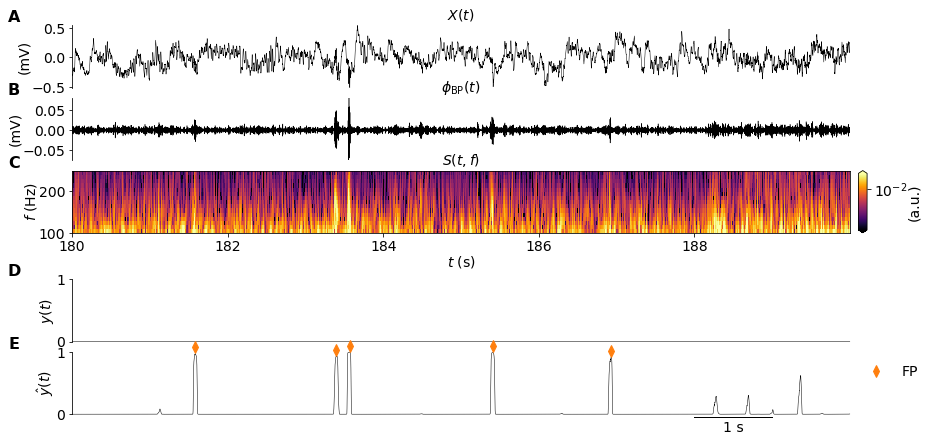

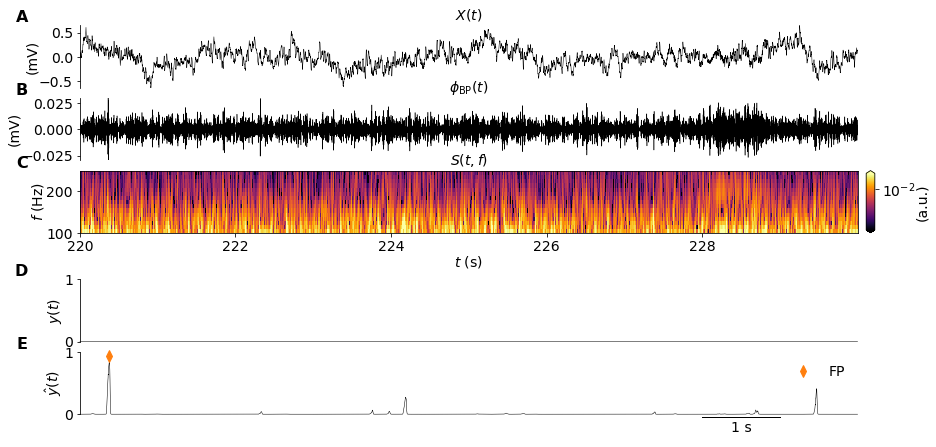

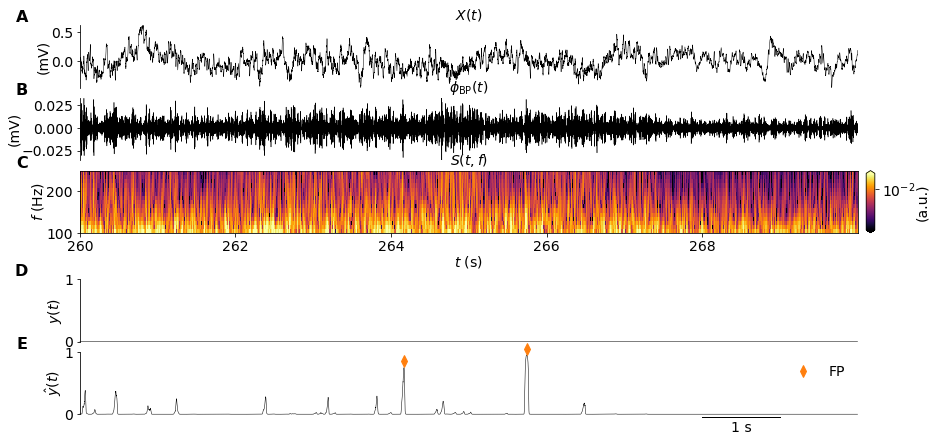

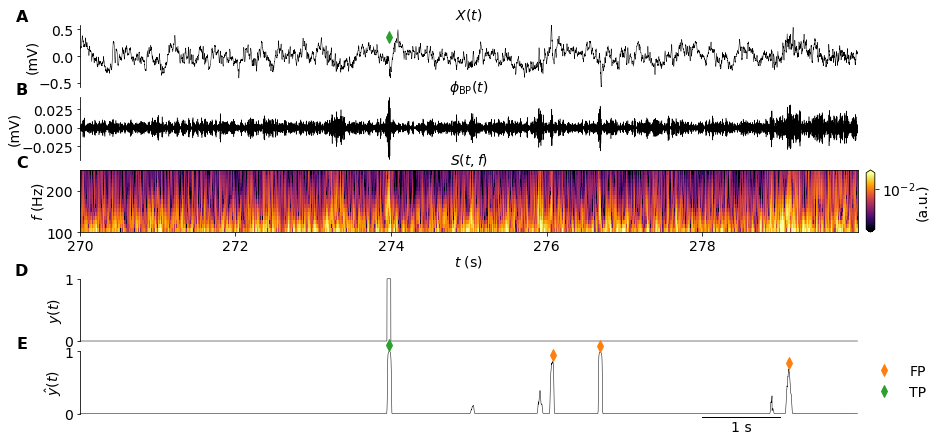

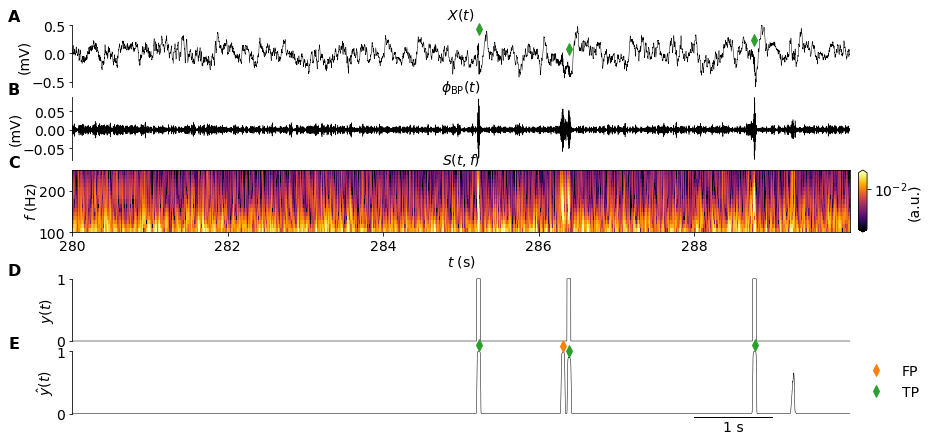

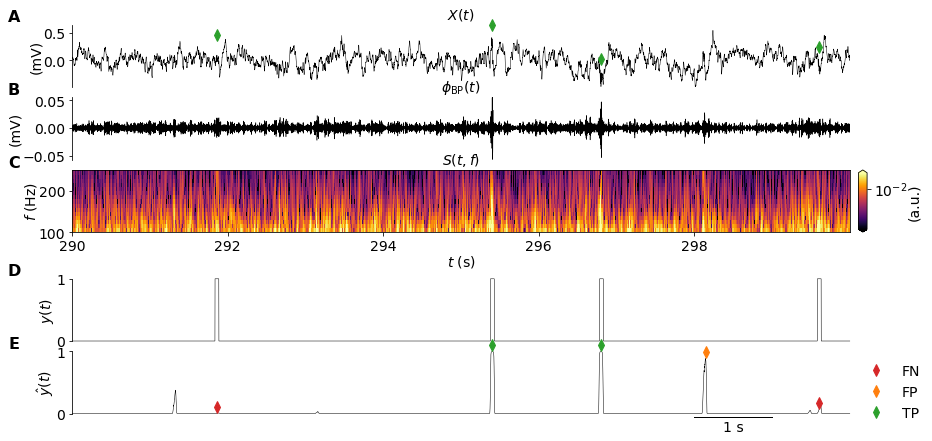

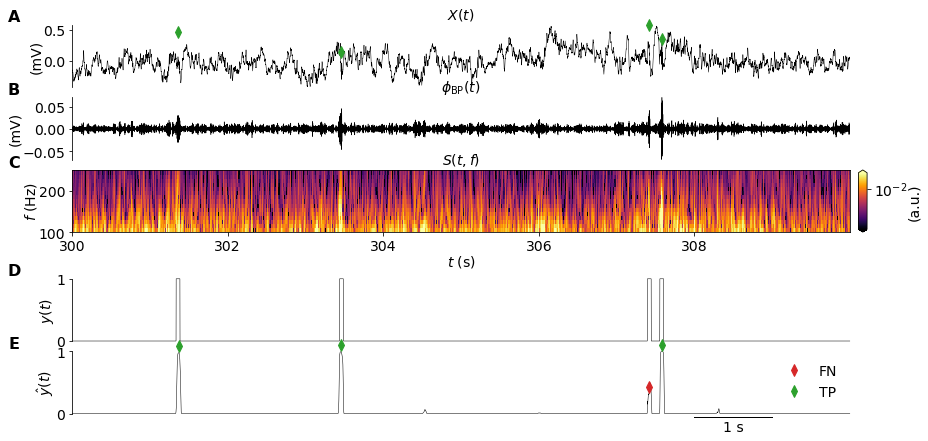

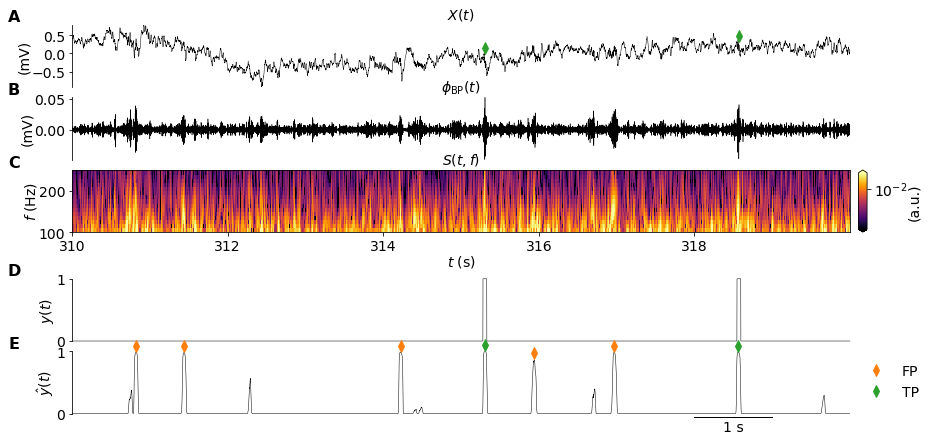

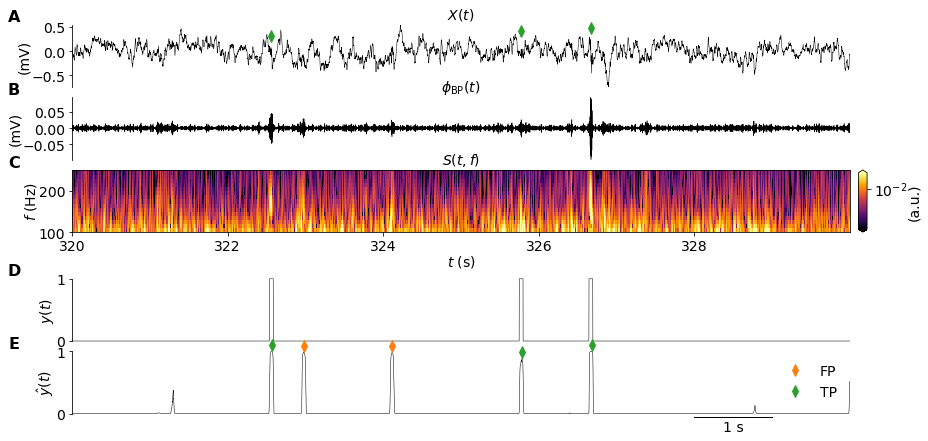

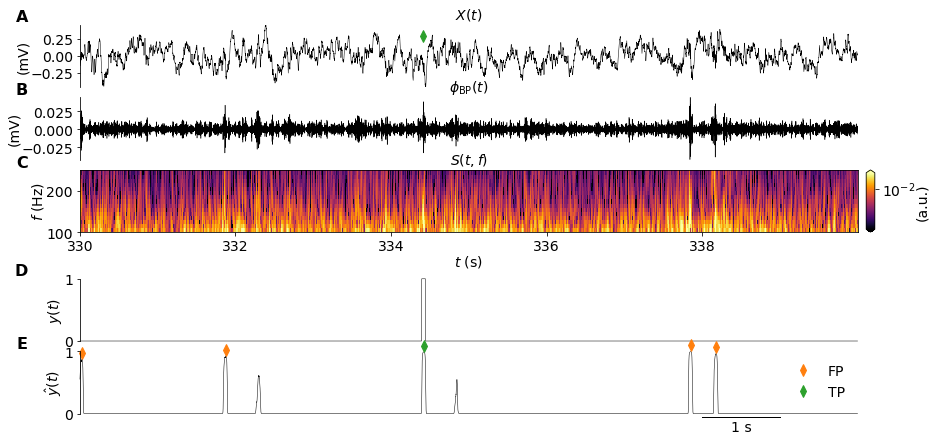

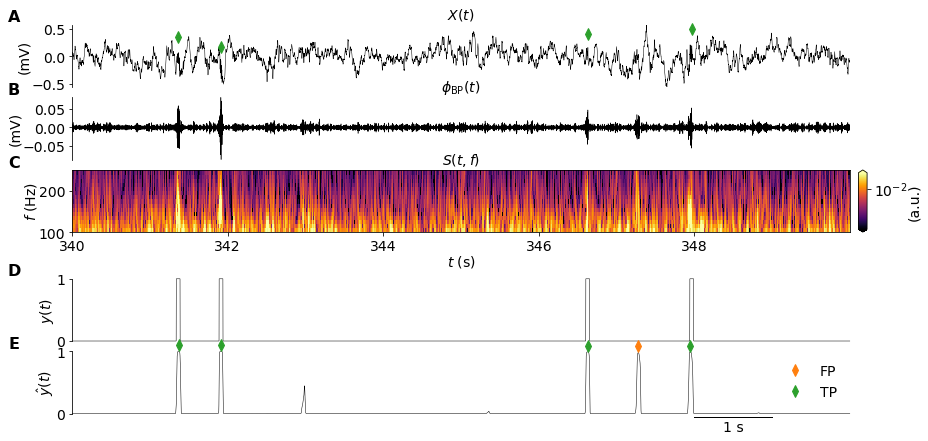

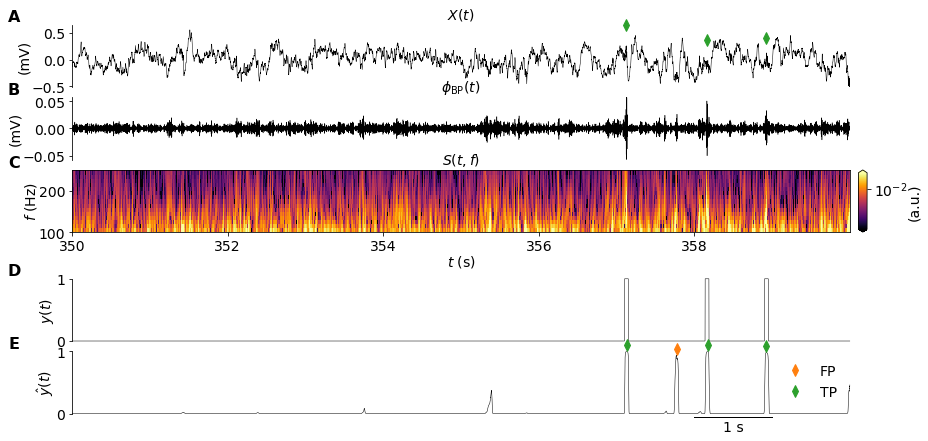

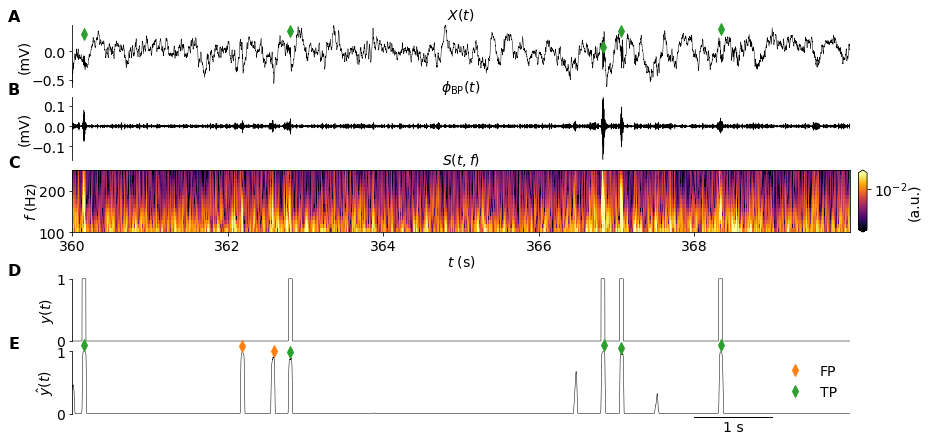

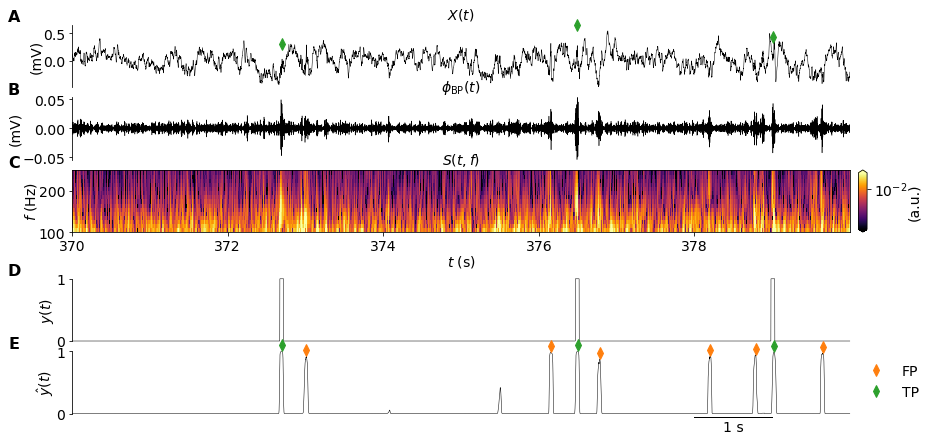

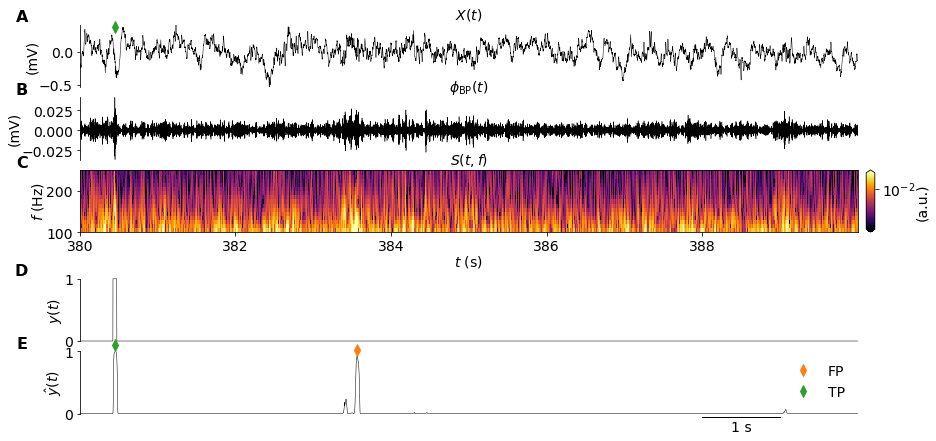

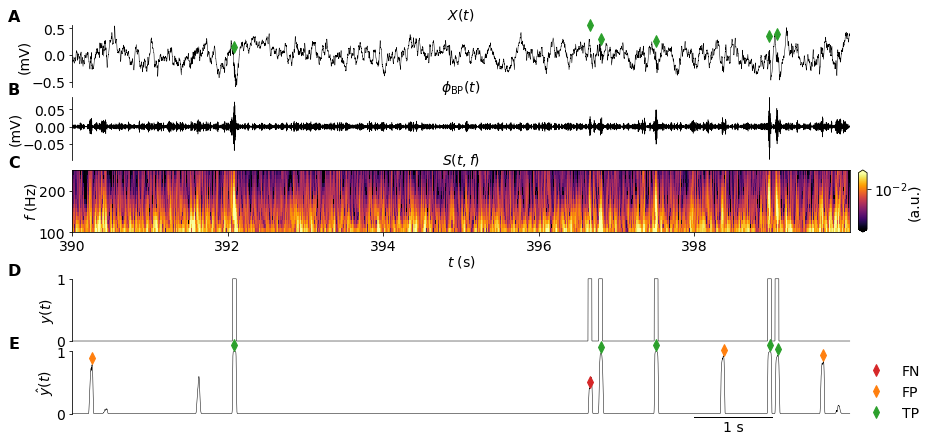

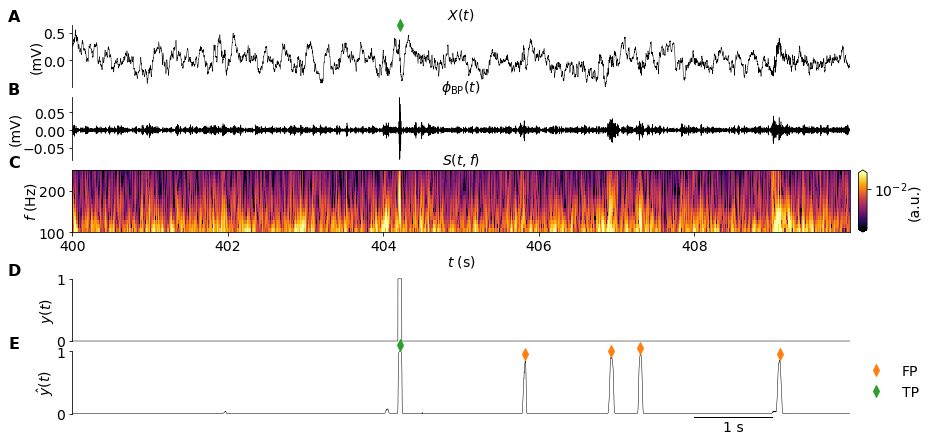

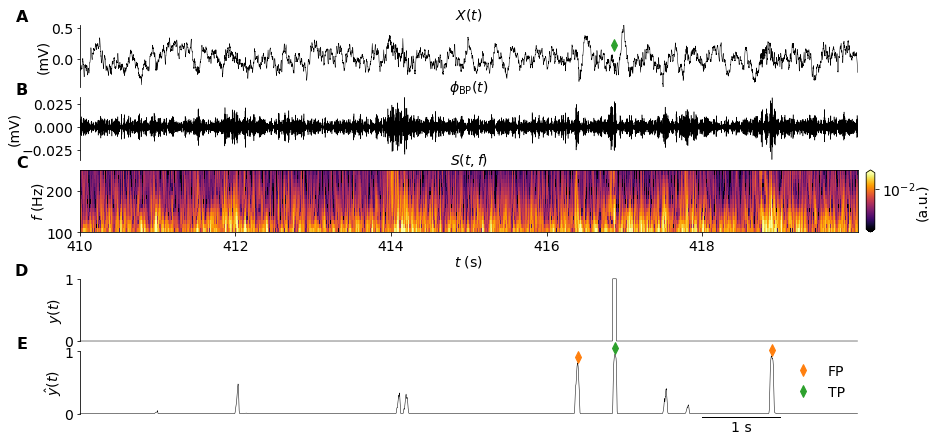

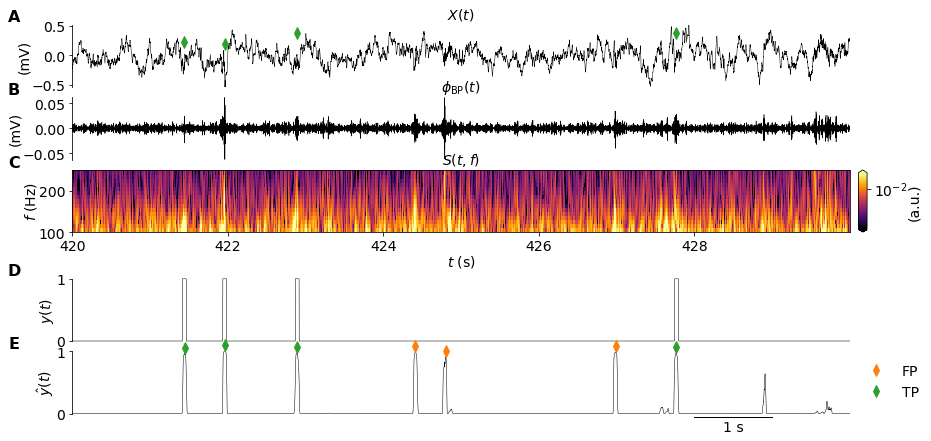

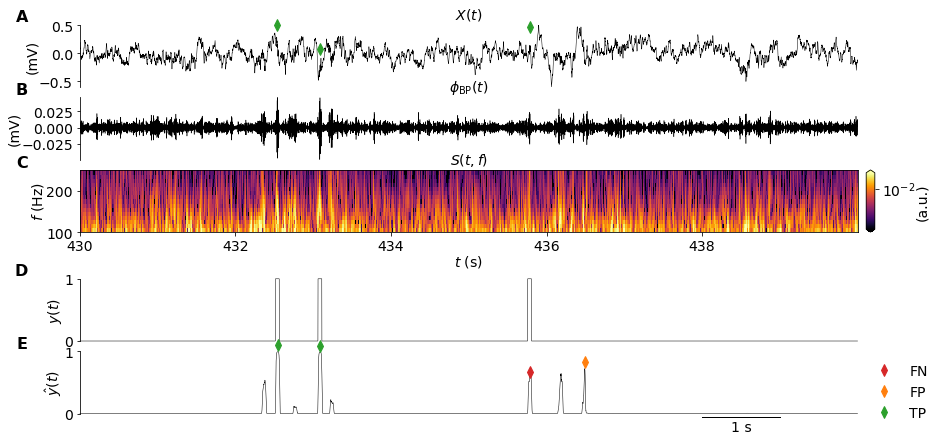

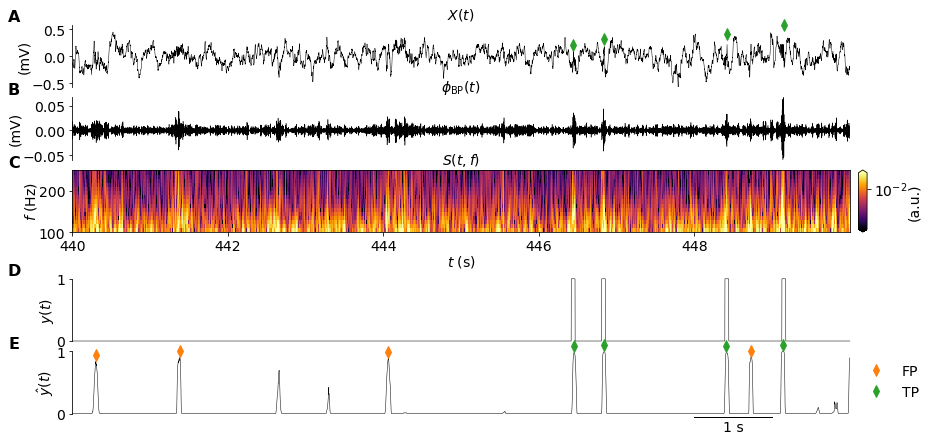

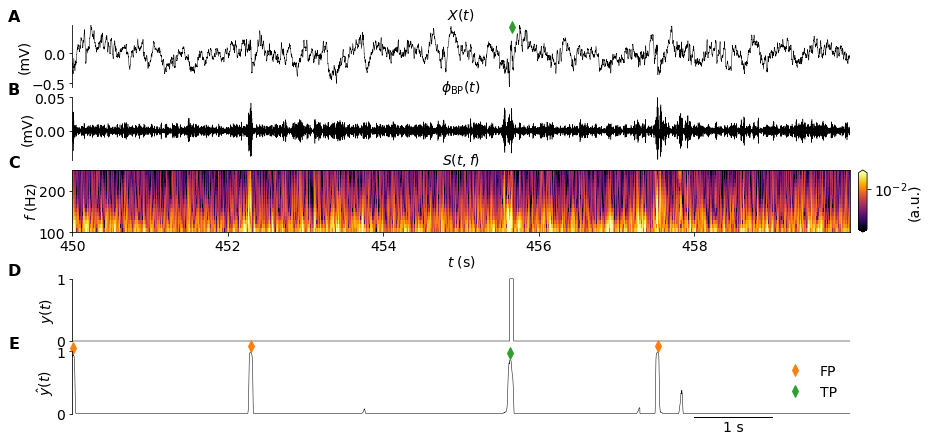

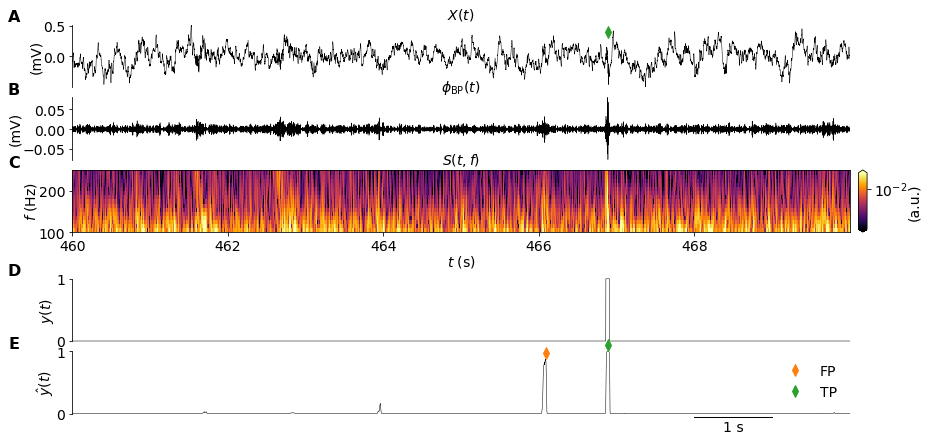

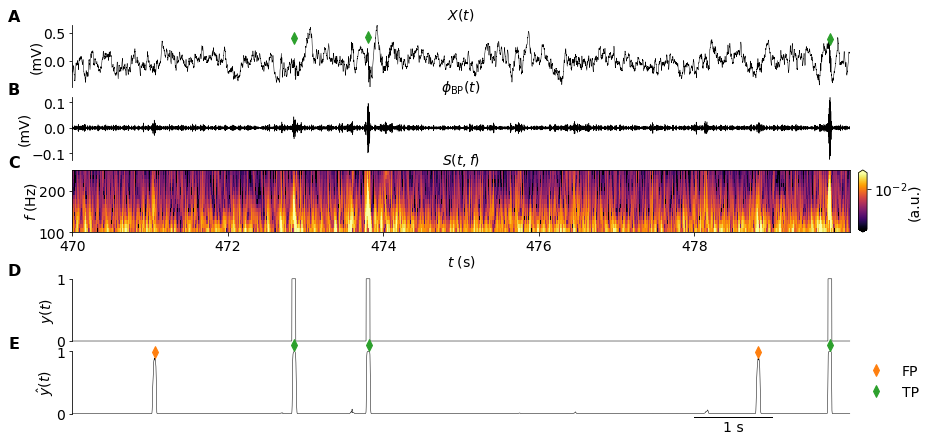

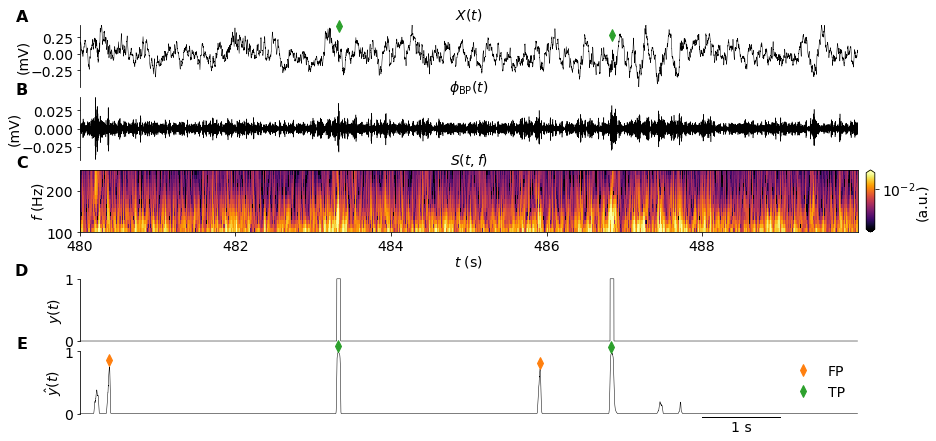

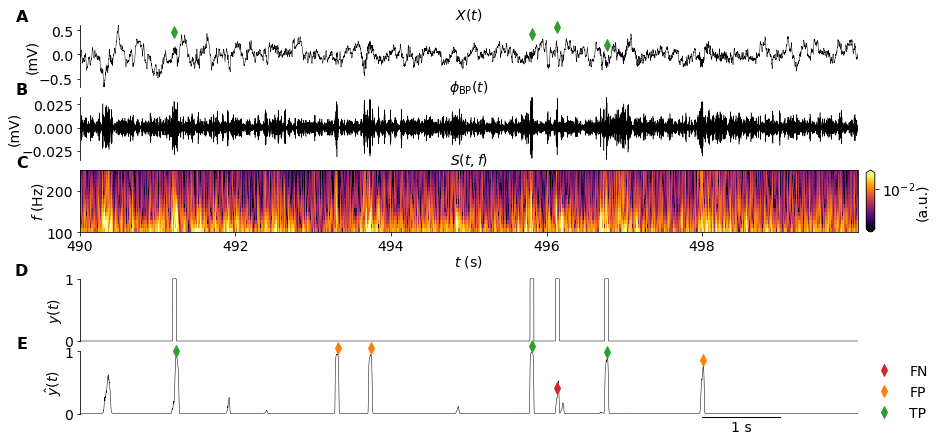

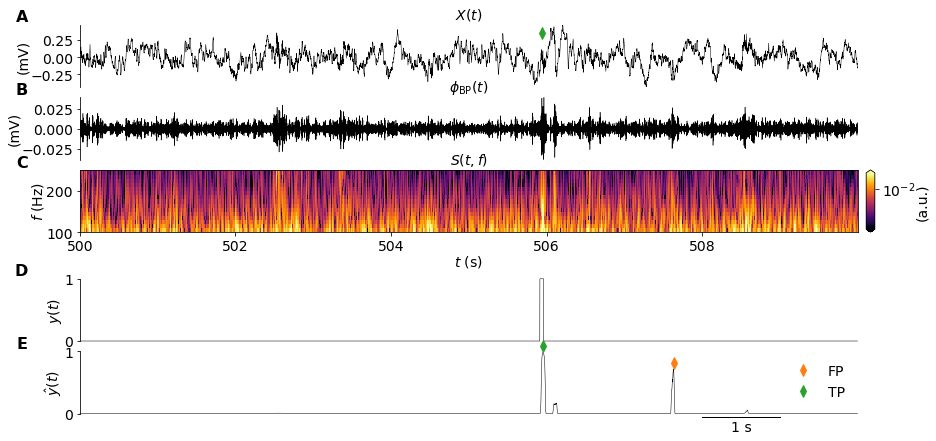

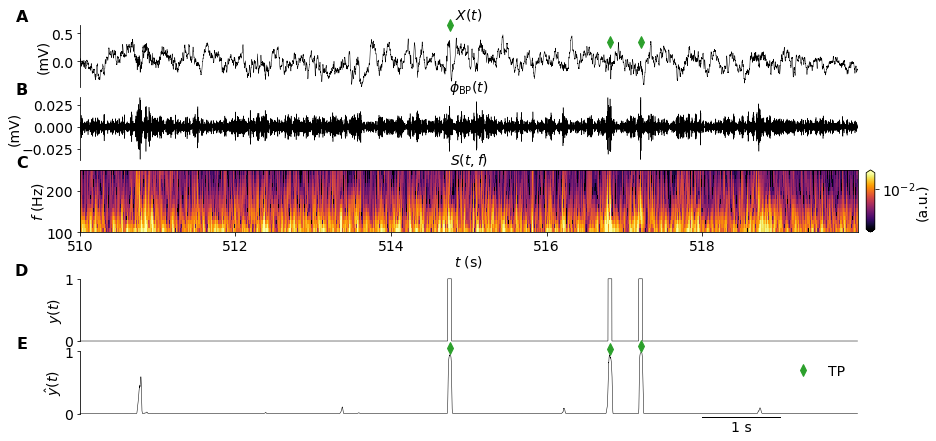

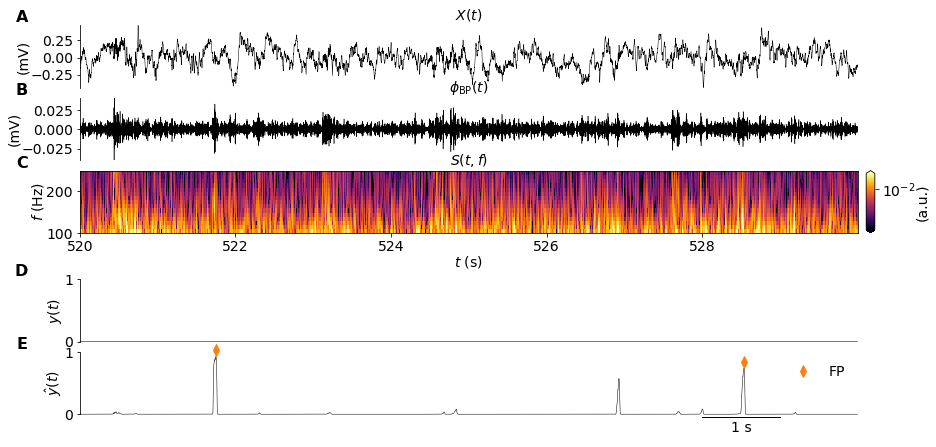

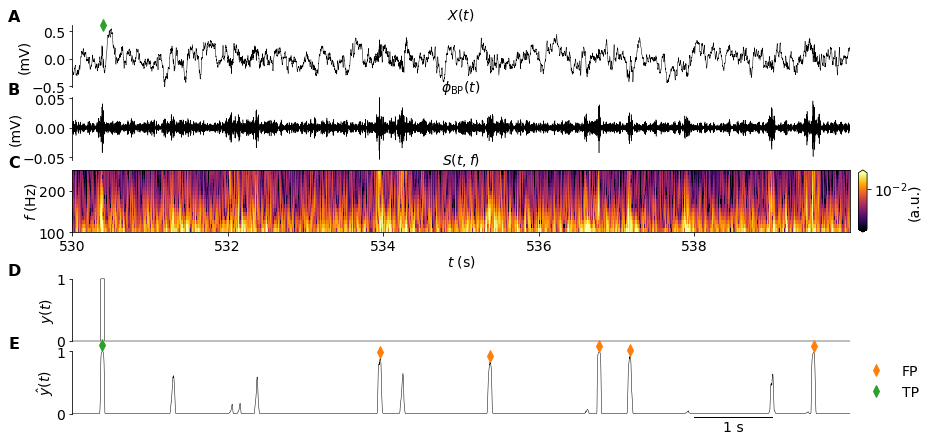

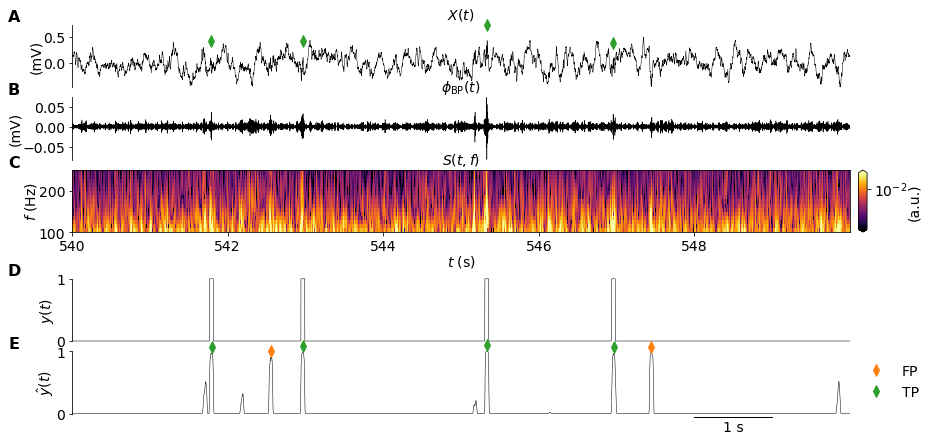

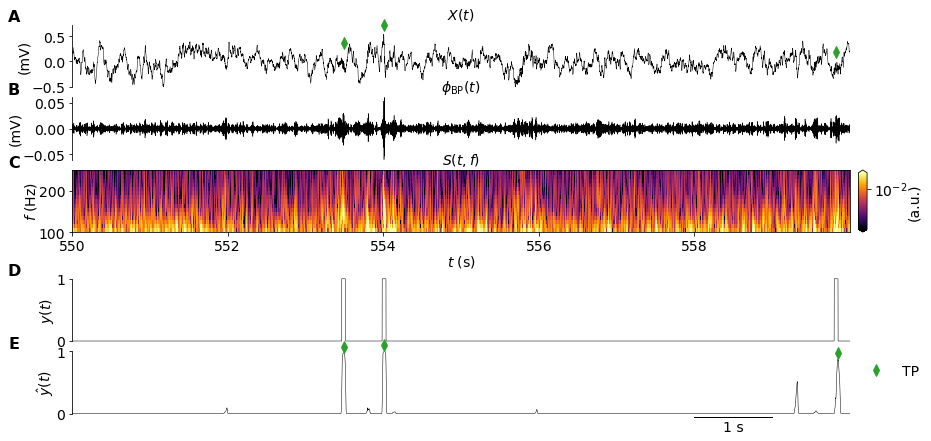

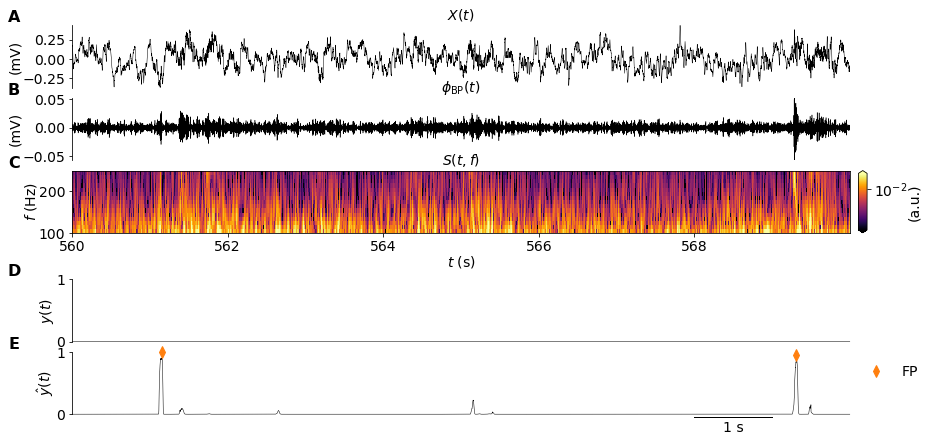

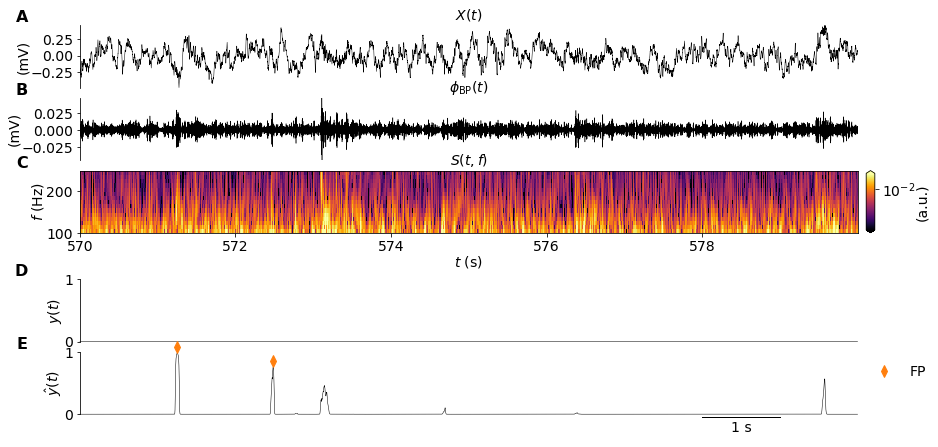

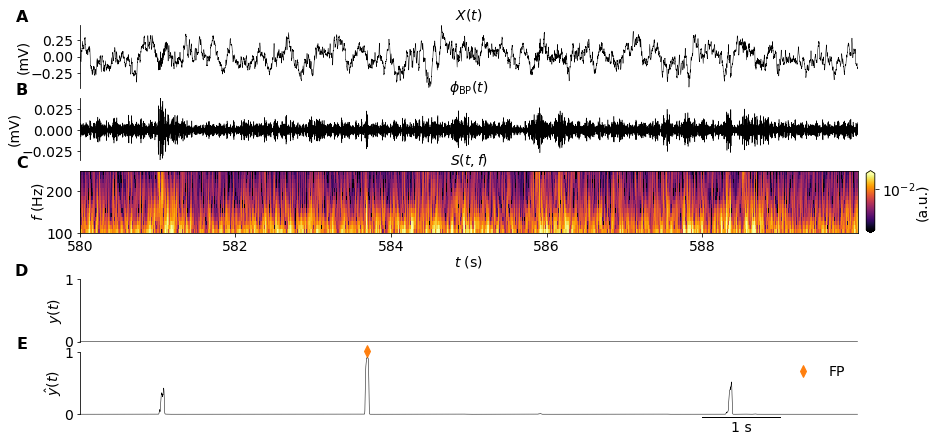

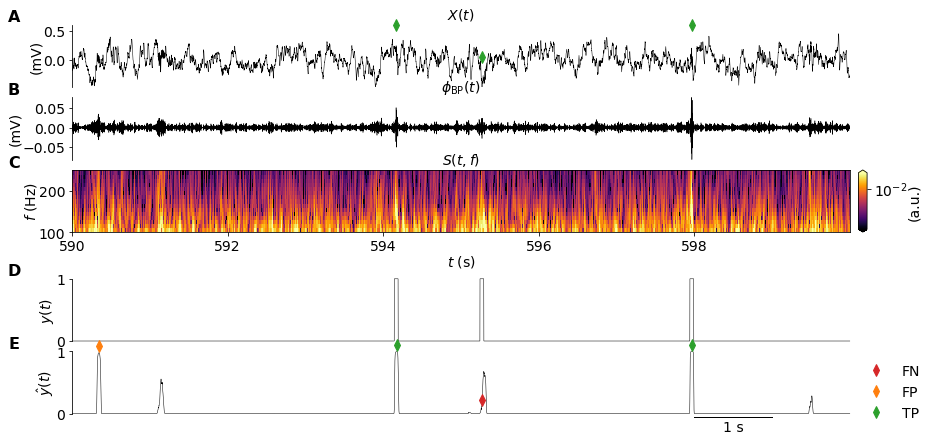

In [27]:
for i in range(Y_cont_pred.size // windowsize):
    inds = np.arange(i*windowsize, windowsize*(i+1))
    time = inds / Fs

    X0 = f[session]['lfp'][:][inds]
    X1 = f[session]['X1'][:][inds]
    S = f[session]['S'][:][inds, ]
    y = f[session]['y'][:][inds]

    y_pred = Y_cont_pred.flatten()[inds]

    peaks__, _ = ss.find_peaks(y_pred, height=threshold, distance=distance, width=width)

    rippleInds = (rippleLocs >= inds.min()) & (rippleLocs < inds.max())
    rippleTimes = rippleLocs[rippleInds]
    
    # skip plot if no events of any kinds are found in segment
    if (rippleTimes.size + peaks__.size) == 0:
        continue

    labels_ = labels[(labels.i >= inds.min()) & (labels.i < inds.max())] 

    fig = plot_figure(X0, X1, S, y, y_pred, time, rippleLocs, inds, peaks, labels_)
    # save figure
    fig.savefig(os.path.join('figures', 'figure8_{}s_{}s.png'.format(int(round(time[0])), int(round(time[-1])))), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)
    #plt.close(fig)

## Figure 9

In [28]:
# compare cumulative counts of events for session
onehot_pred = np.zeros(Y_cont_pred.size)
onehot_pred[peaks] = 1
onehot = np.zeros(Y_cont_pred.size)
onehot[rippleLocs] = 1

In [29]:
# correlation function between rippleLocs and peaks
bin_size = 2.5 # 2 ms at Fs=1250 Hz
n_lags = 51 # 

bin_count = X0_cont.size // bin_size
if (X0_cont.size % bin_size) > 0:
    bin_count += 1
bins = np.arange(bin_count) * bin_size

labels_binned, _ = np.histogram(rippleLocs, bins=bins)
preds_binned, _ = np.histogram(peaks, bins=bins)

Cxy = np.correlate(labels_binned-labels_binned.mean(), 
                    preds_binned-preds_binned.mean(), 'same')[::-1] / \
                        (labels_binned.std() * preds_binned.std() * preds_binned.size) 

lags = (bins - Cxy.size // 2 * bin_size) / Fs * 1000
lag_inds = np.arange(n_lags) + lags.size // 2 - n_lags // 2

#plt.step(lags[lag_inds], Cxy[lag_inds], where='mid')

In [30]:
def get_samples(f, session, inds, lag):

    # create arrays of training and validation samples combining data from all sessions
    X0 = [] # container for raw data segments
    X1 = [] # container for gamma-band data segments
    S = []  # container for specgram
    Y = []  # container for labels
    labels = [] # data labels (session, rippleLoc, offset)

    sample_size = lag * 2

    for ind in inds:
        # center segments on event
        offset = -sample_size // 2        
        
        # extract
        idx = np.arange(sample_size) + ind + offset
        if idx.min() < 0:
            idx -= idx.min()
        elif idx.max() >= f[session]['lfp'].size:
            idx = idx - (idx.max() - f[session]['lfp'].size + 1) 
        X0.append(f[session]['lfp'][:][idx])
        X1.append(f[session]['X1'][:][idx])
        S.append(f[session]['S'][:][idx, ])
        labels.append((session, ind, offset))

    # convert to numpy arrays, downcast to single precision
    X0 = np.array(X0).astype(np.float32)
    X1 = np.array(X1).astype(np.float32)
    S = np.array(S).astype(np.float32)
    #Y = np.array(Y).astype(np.float32)
    #Y[Y>1] = 1 # fix cases where labels overlap (e.g., double-registration)
    labels = np.array(labels, dtype=[('session', 'S16'), ('rippleLocs', np.int32), ('offset', np.int32)])

    return X0, X1, S, labels

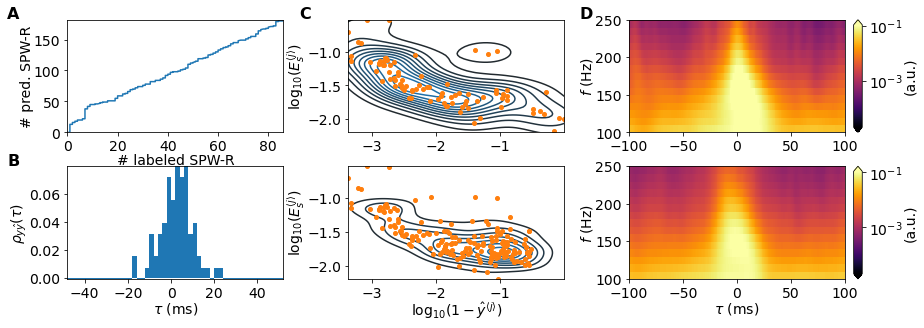

In [31]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(2,3, left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.3, hspace=0.3)

# cumulative counts
ax = fig.add_subplot(gs[0, 0])
ax.plot(onehot.cumsum(), onehot_pred.cumsum())
ax.set_xlabel('# labeled SPW-R', labelpad=0)
ax.set_ylabel('# pred. SPW-R', labelpad=0)
annotate_subplot(ax, ncols=10, nrows=2, letter='A')

# correlation function
ax = fig.add_subplot(gs[1, 0])
#ax.step(lags[lag_inds], Cxy[lag_inds], where='mid')
ax.fill_between(lags[lag_inds], Cxy[lag_inds], step='pre')
ax.set_xlabel(r'$\tau$ (ms)', labelpad=0)
ax.set_ylabel(r'$\rho_{y\hat{y}}(\tau)$', labelpad=0)
annotate_subplot(ax, ncols=10, nrows=2, letter='B')

# energy vs (1-y)
ax0 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[1, 1], sharex=ax0, sharey=ax0)

lag = int(100 * Fs / 1000) # 100 ms @ Fs
y_max_labeled = Y_cont_pred[0, rippleLocs + np.expand_dims(np.arange(-31, 32), -1), 0].max(axis=0)
y_max_pred = Y_cont_pred[0, peaks, 0]
E_s = []
for j, (inds, confidence, marker, label, ax) in enumerate(zip([rippleLocs, peaks], 
                                                          [y_max_labeled, y_max_pred], 
                                                          ['.', '.'],
                                                          [r'$y$', r'$\hat{y}$'],
                                                          [ax0, ax1] 
                                                         )):
    _, X1_, _, _ = get_samples(f, session, inds, lag)
    # energy measure
    E_s.append(np.sum(X1_**2, axis=1))
    sns.kdeplot(np.log10(1-confidence), np.log10(E_s[-1]), ax=ax, cbar=False, shade=False)
    ax.plot(np.log10(1-confidence), np.log10(E_s[-1]), marker, ms=8, alpha=1, label=label)
    ax.set_ylabel(r'$\log_{10}(E_s^{\langle j \rangle})$', labelpad=0)
xvals = np.log10(1-np.r_[y_max_labeled, y_max_pred])
yvals = np.log10(np.r_[E_s[0], E_s[1]])
ax1.set_xlim(xvals.min(), xvals.max())
ax1.set_ylim(yvals.min(), yvals.max())
ax1.set_xlabel(r'$\log_{10}(1-\hat{y}^{\langle j \rangle})$', labelpad=0)
annotate_subplot(ax0, ncols=8, nrows=2, letter='C')


# averaged SPW-R spectrograms
time = np.arange(-lag, lag+1) / Fs * 1000
for j, inds in enumerate([rippleLocs, peaks]): 
    X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

    ax = fig.add_subplot(gs[j, 2])

    #vmin, vmax = np.exp(np.percentile(np.log(S_cont.flatten()), [1, 99]))
    im = ax.pcolormesh(time, S_freqs, S_.mean(axis=0).T, 
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno',
                        label='spectrogram')
    #if j == 1:
    rect = np.array(ax.get_position().bounds)
    rect[0] += rect[2] + 0.01
    rect[2] = 0.01
    fig = plt.gcf()
    cax = fig.add_axes(rect)
    
    cbar = fig.colorbar(im, cax=cax, extend='both')
    cbar.set_label('(a.u.)', labelpad=0)
    ax.axis(ax.axis('tight'))
    ax.set_ylabel('$f$ (Hz)', labelpad=0)
    if j == 1:
        ax.set_xlabel(r'$\tau$ (ms)', labelpad=0)
    if j == 0:
        annotate_subplot(ax, ncols=8, nrows=2, letter='D')

# save figure
fig.savefig(os.path.join('figures', 'figure9.png'), dpi=300, bbox_inches='tight', pad_inches=0.05)

## Compare SPW-R predictions to labeled events
input, filtered LFPs, spectrograms

In [32]:
n_samples = 10
lag = int(100 * Fs / 1000) # 100 ms @ Fs
time = np.arange(-lag, lag) / Fs * 1000

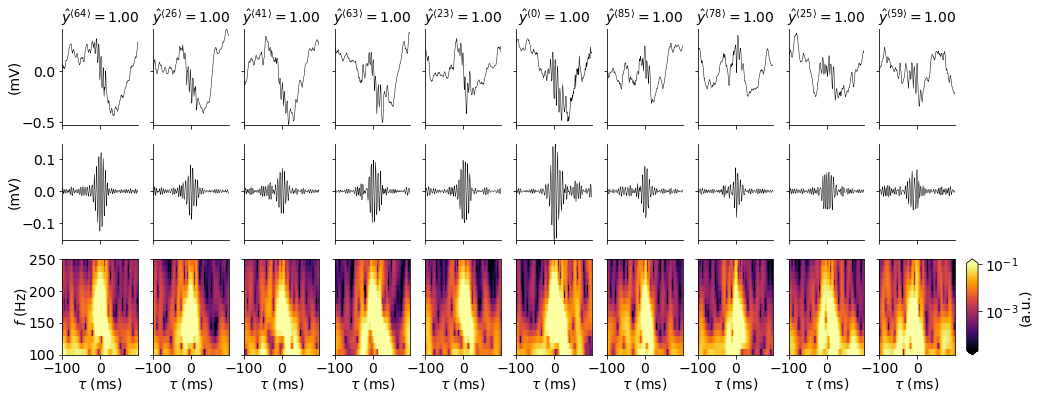

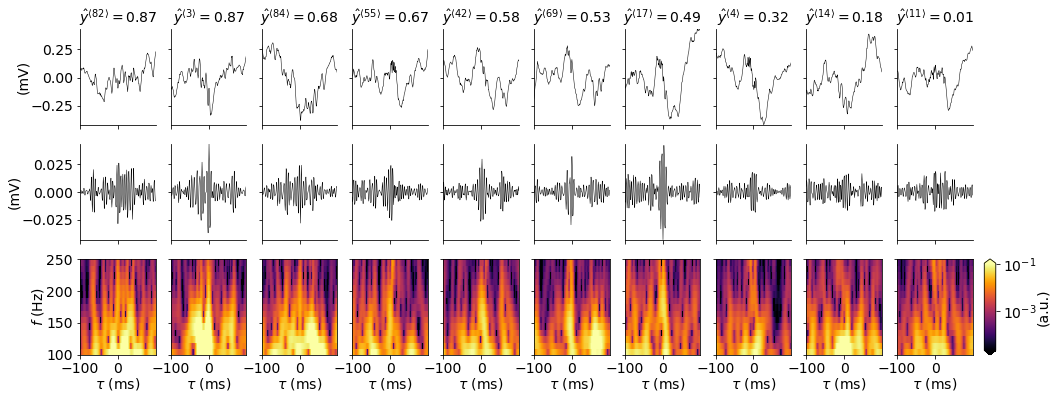

In [33]:
# plot labeled ripple events with scores by the RippleNet 
n_plots = rippleLocs.size // 10
if rippleLocs.size % 10 > 0:
    n_plots += 1

# get scoring at times of labeled rippleLocs
confidence = Y_cont_pred[0, rippleLocs + np.expand_dims(np.arange(-31, 32), -1), 0].max(axis=0) 
sort = np.argsort(confidence)[::-1]

#for k in range(n_plots):
#    inds_labeled = rippleLocs[sort][k*n_samples:(k+1)*n_samples]
#    conf_labeled = confidence[sort][k*n_samples:(k+1)*n_samples]
#    j_super = np.arange(rippleLocs.size)[sort][k*n_samples:(k+1)*n_samples]

# plot only the n_samples best and worst examples
for k, inds in enumerate([np.arange(rippleLocs.size)[:n_samples], 
                          np.arange(rippleLocs.size)[-n_samples:]]):
    inds_labeled = rippleLocs[sort][inds]
    conf_labeled = confidence[sort][inds]
    j_super = np.arange(rippleLocs.size)[sort][inds]

    for j, (inds, dataset) in enumerate(zip([inds_labeled], ['labeled'])): 
        fig, axes = plt.subplots(3, n_samples, figsize=(16, 6), sharex=True, sharey='row')
        X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

        for i in range(n_samples):
            # raw LFP with ripple label
            ax0 = axes[0, i]
            try:
                ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
                        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
            except IndexError:
                for ax in axes[:, i]:
                    ax.axis('off')
                continue

            if i == 0:
                ax0.set_ylabel('(mV)', labelpad=0)
            ax0.axis(ax0.axis('tight'))
            for spine in ['top', 'right']:
                ax0.spines[spine].set_visible(False)
            ax0.set_title(r'$\hat{y}^{\langle ' + str(np.where(rippleLocs==inds[i])[0][0]) + 
                          r' \rangle}=' + '{:.2f}'.format(conf_labeled[i].max()) + r'$')


            # band-pass filtered LFP
            ax2 = axes[1, i]
            ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
            ax2.axis(ax2.axis('tight'))
            if i == 0:
                ax2.set_ylabel('(mV)', labelpad=0)
            for spine in ['top', 'right']:
                ax2.spines[spine].set_visible(False)
            
            ax3 = axes[2, i]
            im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                cmap='inferno',
                                label='spectrogram')
            if i == n_samples-1:
                rect = np.array(ax3.get_position().bounds)
                rect[0] += rect[2] + 0.01
                rect[2] = 0.01
                fig = plt.gcf()
                cax = fig.add_axes(rect)

                cbar = fig.colorbar(im, cax=cax, extend='both')
                cbar.set_label('(a.u.)', labelpad=0)
            ax3.axis(ax3.axis('tight'))
            if i == 0:
                ax3.set_ylabel('$f$ (Hz)', labelpad=0)
            ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)


    fig.savefig(os.path.join('figures', 'figure10_{}_{}.png'.format(dataset, k)), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)

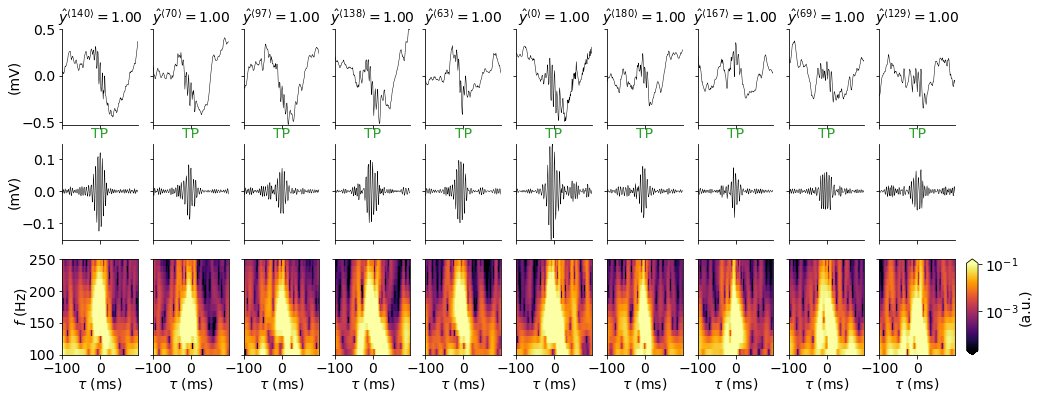

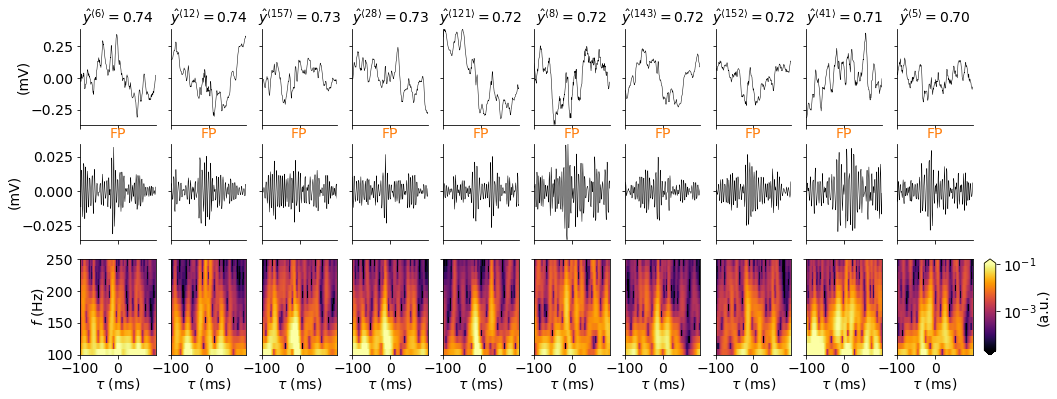

In [34]:
# Draw input and spectrograms for predictions, sort accd. to confidence (highest first).  
n_plots = peaks.size // 10
if peaks.size % 10 > 0:
    n_plots += 1

confidence = Y_cont_pred[0, peaks, 0]
sort = np.argsort(confidence)[::-1]

#for k in range(n_plots):
#    inds_pred = peaks[sort][k*n_samples:(k+1)*n_samples]
#    conf_pred = confidence[sort][k*n_samples:(k+1)*n_samples]
#    label_labeled = labels.loc[sort][k*n_samples:(k+1)*n_samples]
#    j_super = np.arange(peaks.size)[sort][k*n_samples:(k+1)*n_samples]

# plot only the n_samples best and worst examples
for k, inds in enumerate([np.arange(peaks.size)[:n_samples], 
                          np.arange(peaks.size)[-n_samples:]]):
    inds_pred = peaks[sort][inds]
    conf_pred = confidence[sort][inds]
    label_labeled = labels.loc[sort].reset_index().loc[inds] #labels.loc[sort][inds]
    j_super = np.arange(peaks.size)[sort][inds]

    for j, (inds, dataset) in enumerate(zip([inds_pred], ['predicted'])): 
        fig, axes = plt.subplots(3, n_samples, figsize=(16, 6), sharex=True, sharey='row')
        X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

        for i in range(n_samples):
            # raw LFP with ripple label
            ax0 = axes[0, i]
            try:
                ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
                        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
            except IndexError:
                for ax in axes[:, i]:
                    ax.axis('off')
                continue
                
            if i == 0:
                ax0.set_ylabel('(mV)', labelpad=0)
            ax0.axis(ax0.axis('tight'))
            for spine in ['top', 'right']:
                ax0.spines[spine].set_visible(False)
            ax0.set_title(r'$\hat{y}^{\langle ' + str(j_super[i]) + 
                          r' \rangle}=' + '{:.2f}'.format(conf_pred[i]) + r'$')

            # band-pass filtered LFP
            ax2 = axes[1, i]
            ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
            ax2.axis(ax2.axis('tight'))
            if i == 0:
                ax2.set_ylabel('(mV)', labelpad=0)
            for spine in ['top', 'right']:
                ax2.spines[spine].set_visible(False)
            
            ax2.set_title(label_labeled.label.values[i], 
                          color=label_labeled.color.values[i])

            
            ax3 = axes[2, i]
            im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                cmap='inferno',
                                label='spectrogram')
            if i == n_samples-1:
                rect = np.array(ax3.get_position().bounds)
                rect[0] += rect[2] + 0.01
                rect[2] = 0.01
                fig = plt.gcf()
                cax = fig.add_axes(rect)
                
                cbar = fig.colorbar(im, cax=cax, extend='both')
                cbar.set_label('(a.u.)', labelpad=0)
            ax3.axis(ax3.axis('tight'))
            if i == 0:
                ax3.set_ylabel('$f$ (Hz)', labelpad=0)
            ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)


        fig.savefig(os.path.join('figures', 'figure10_{}_{}.png'.format(dataset, k)), 
                    dpi=300, bbox_inches='tight', pad_inches=0.05)

# panel C for figure 1 

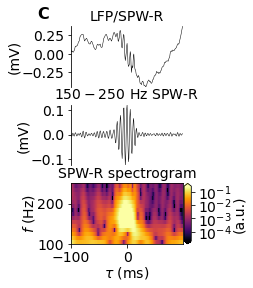

In [35]:

confidence = Y_cont_pred[0, peaks, 0]
sort = np.argsort(confidence)[::-1]

k = 0
inds = np.array([0])

inds_pred = peaks[sort][inds]
conf_pred = confidence[sort][inds]
label_labeled = labels.loc[sort].reset_index().loc[inds] #labels.loc[sort][inds]
j_super = np.arange(peaks.size)[sort][inds]


inds = inds_pred

fig = plt.figure(figsize=(2,4))
gs = GridSpec(3, 1, hspace=0.3)

X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

i = 0

# raw LFP with ripple label
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
ax0.set_ylabel('(mV)', labelpad=0)
ax0.axis(ax0.axis('tight'))
for spine in ['top', 'right', 'bottom']:
    ax0.spines[spine].set_visible(False)
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.set_title('LFP/SPW-R')
annotate_subplot(ax0, ncols=10, nrows=8, letter='C')

# band-pass filtered LFP
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
ax2.axis(ax2.axis('tight'))
ax2.set_ylabel('(mV)', labelpad=0)
for spine in ['top', 'right', 'bottom']:
    ax2.spines[spine].set_visible(False)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_title(r'$150-250$ Hz SPW-R')


# spectrogram
#ax3 = axes[2]
ax3 = fig.add_subplot(gs[2:, 0])
vmin, vmax_ = np.exp(np.percentile(np.log(f[session]['S'][:Fs*30, :].flatten()), [1, 99.9]))
#levels = np.linspace(vmin, vmax_, 20)
im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                    norm=colors.LogNorm(vmin=vmin, vmax=vmax_),
                    cmap='inferno',
                    label='spectrogram',
                    #levels=levels,
                    rasterized=True)
rect = np.array(ax3.get_position().bounds)
rect[0] += rect[2] + 0.01
rect[2] = 0.05
fig = plt.gcf()
cax = fig.add_axes(rect)

cbar = fig.colorbar(im, cax=cax, extend='both')
cbar.set_ticks(10.**np.arange(-5, 5))
cbar.set_label('(a.u.)', labelpad=0)
ax3.axis(ax3.axis('tight'))
if i == 0:
    ax3.set_ylabel('$f$ (Hz)', labelpad=0)
ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)
ax3.set_title('SPW-R spectrogram')


fig.savefig(os.path.join('figures', 'figure0C.png'.format(dataset, k)), 
            dpi=300, bbox_inches='tight', pad_inches=0.0)
fig.savefig(os.path.join('figures', 'figure0C.pdf'.format(dataset, k)), 
            dpi=300, bbox_inches='tight', pad_inches=0.0)